In [ ]:
!pip install jax jaxlib
!pip install --quiet --upgrade scipy
!pip install --quiet jax jaxlib optax

In [7]:
import warnings
warnings.filterwarnings("ignore", message="Transparent hugepages are not enabled.*")
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm as jax_norm
from scipy.stats import norm as sp_norm
import time
from numpy.polynomial.legendre import leggauss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, brentq, minimize
from scipy.special import gamma
from math import log
from numpy.random import default_rng, SeedSequence
from scipy.stats import kstwobign, cramervonmises, uniform
from joblib import Parallel, delayed
from itertools import zip_longest
from collections import OrderedDict
import logging
logging.getLogger("matplotlib.backends.backend_ps").setLevel(logging.ERROR)


# ==============================================================
# ETLL ARE Table
# ==============================================================


Table 2: ARE values α=2.0, β=0.5
       0.3    0.5    0.8    1.0    1.3    2.0    5.0    7.0    9.0    10.0
0.3   0.118  0.292  0.761  0.946  0.914  0.555  0.059  0.021  0.002  0.001
0.5   0.112  0.275  0.733  0.944  0.966  0.669  0.119  0.050  0.025  0.019
0.8   0.104  0.253  0.687  0.918  0.997  0.787  0.219  0.117  0.071  0.057
1.0   0.100  0.240  0.657  0.894  0.999  0.839  0.285  0.168  0.110  0.092
1.2   0.096  0.228  0.628  0.866  0.992  0.875  0.346  0.219  0.153  0.130
2.0   0.083  0.191  0.528  0.758  0.924  0.927  0.531  0.397  0.315  0.285
4.0   0.063  0.138  0.374  0.557  0.729  0.840  0.697  0.608  0.543  0.517
5.0   0.057  0.123  0.326  0.490  0.652  0.778  0.707  0.639  0.587  0.565
7.0   0.049  0.100  0.260  0.393  0.536  0.669  0.679  0.642  0.609  0.594
10.0  0.041  0.080  0.200  0.303  0.422  0.546  0.608  0.595  0.580  0.573

⭐ Maximum ARE = 0.999 at a=1.0, b=1.3


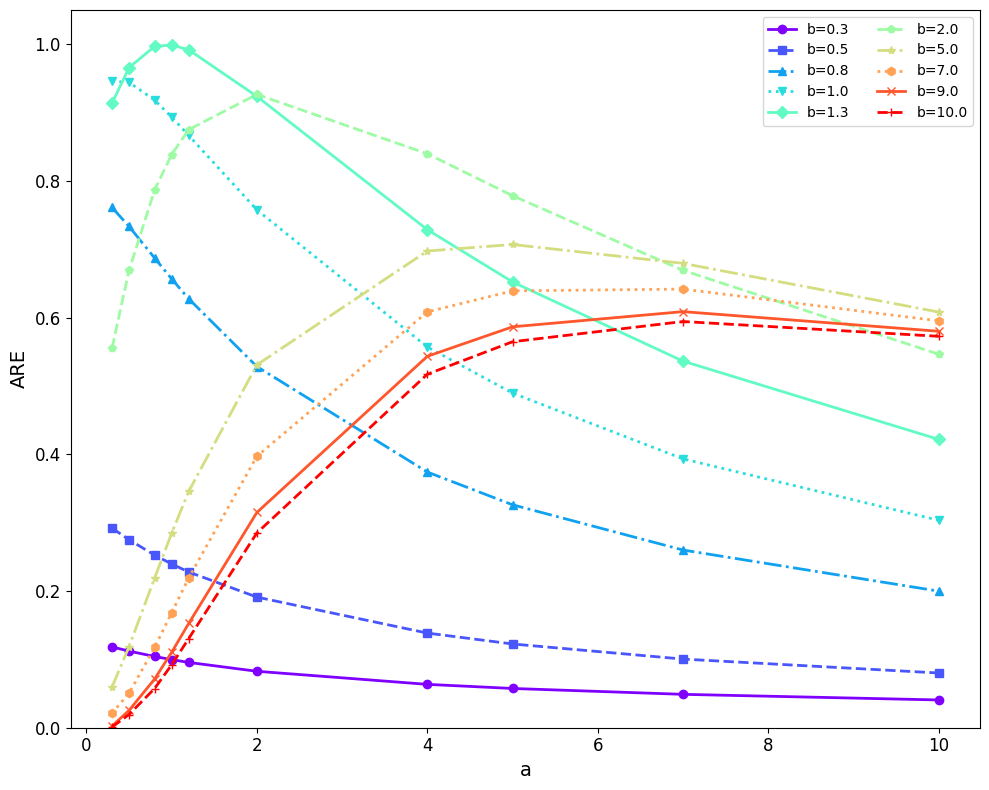


⏱️ Total runtime: 22.46 s


In [8]:
# ==============================================================
# ETLL ARE Table
# ==============================================================

# ---------- pretty, wide table printing ----------
pd.set_option("display.width", 2000)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)


class ETLLARE:
    def __init__(self, theta=1.0, kuma_a=1.0, kuma_b=1.0, n_quad=200):
        self.theta = theta
        self.kuma_a = kuma_a
        self.kuma_b = kuma_b
        self.n_quad = n_quad
        # Precompute Gauss–Legendre nodes & weights
        self.nodes, self.weights = np.polynomial.legendre.leggauss(n_quad)
        # Transform nodes from [-1,1] → [0,1]
        self.u = 0.5 * (self.nodes + 1)
        self.w = 0.5 * self.weights

    def kumaraswamy_weight(self, u, a=None, b=None):
        if a is None: a = self.kuma_a
        if b is None: b = self.kuma_b
        return a * b * (u ** (a - 1)) * ((1 - u**a) ** (b - 1))

    # ---- Ck integral using Gauss–Legendre ----
    def compute_ck(self, beta, k):
        u, w = self.u, self.w
        weights = self.kumaraswamy_weight(u)
        base = 2**beta - (2**beta - 1) * u
        mask = base > 0
        term = np.zeros_like(u)
        term[mask] = base[mask]**(1/beta) - 1
        valid = term > 0
        integrand = np.zeros_like(u)
        integrand[valid] = weights[valid] * (np.log(term[valid])**k)
        return np.sum(w * integrand)

    def tau(self, beta):
        C1 = self.compute_ck(beta, 1)
        C2 = self.compute_ck(beta, 2)
        return C2 - C1**2

    def solve_beta(self, mu1, mu2, beta_range=(-3, 3)):
        Delta = mu2 - mu1**2
        def f(beta):
            C1 = self.compute_ck(beta, 1)
            t = self.tau(beta)
            if t <= 0 or Delta <= 0: return np.nan
            return C1/np.sqrt(t) - (np.log(self.theta)-mu1)/np.sqrt(Delta)

        from scipy.optimize import brentq
        beta_hat = brentq(f, beta_range[0], beta_range[1])
        C1 = self.compute_ck(beta_hat, 1)
        t = self.tau(beta_hat)
        alpha_hat = np.sqrt(t/Delta)
        return alpha_hat, beta_hat

    # ---- Variance–covariance matrix via Λ integrals ----
    def compute_lambda_integral(self, type_num, alpha, beta):
        u, w = self.u, self.w
        weights = self.kumaraswamy_weight(u)

        base = 2**beta - (2**beta - 1) * u
        term = np.where(base > 0, base**(1/beta) - 1, np.nan)
        g = np.where(term > 0, base**(1/beta - 1)/term, 0.0)
        ell = np.where(term > 0, np.log(term), 0.0)

        # kernel K(v,w)
        def kernel(v, w): return np.minimum(v,w) - v*w

        result = 0.0
        for i in range(len(u)):
            for j in range(len(u)):
                if type_num == 1:
                    val = weights[i]*weights[j]*kernel(u[i],u[j])*g[i]*g[j]
                elif type_num == 2:
                    val = weights[i]*weights[j]*kernel(u[i],u[j])*g[i]*ell[j]*g[j]
                elif type_num == 3:
                    val = weights[i]*weights[j]*kernel(u[i],u[j])*ell[i]*g[i]*ell[j]*g[j]
                else:
                    raise ValueError("Invalid type_num")
                result += w[i]*w[j]*val
        return result

    def compute_variance_covariance(self, alpha, beta):
        c = ((2**beta - 1)/(alpha*beta))**2
        L1 = self.compute_lambda_integral(1, alpha, beta)
        L2 = self.compute_lambda_integral(2, alpha, beta)
        L3 = self.compute_lambda_integral(3, alpha, beta)
        Sigma11 = c * L1
        Sigma12 = c * (2*np.log(self.theta)*L1 - 2/alpha*L2)
        Sigma22 = c * (4*np.log(self.theta)**2*L1 - 8*np.log(self.theta)/alpha*L2 + 4/alpha**2*L3)
        return np.array([[Sigma11, Sigma12],[Sigma12, Sigma22]])

    def fisher_information(self, alpha, beta, n):
        t = np.linspace(1e-6, 1-1e-6, 540)
        I_bm1 = np.trapezoid(np.log(t)*(1+t)**(beta-1), t)
        I_bm3_2 = np.trapezoid((np.log(t)**2)*(1+t)**(beta-3), t)
        two_pow_beta = 2**beta; denom = two_pow_beta-1
        Iaa = (1/alpha**2)*(1 - ((beta-1)/(beta-2))*(1+beta+(beta/denom)*(2*beta*I_bm1+(beta-1)*I_bm3_2)))
        Ibb = (1/beta**2)*(1 - (two_pow_beta*beta**2*(np.log(2)**2))/(denom**2))
        Iab = (1/(alpha*(beta-1)))*(1+(beta*I_bm1)/denom)
        return n*np.array([[Iaa,Iab],[Iab,Ibb]])

    # ---- ARE ----
    def compute_ARE(self, mu1, mu2, n):
        alpha_hat, beta_hat = self.solve_beta(mu1, mu2)
        Sigma = self.compute_variance_covariance(alpha_hat, beta_hat)/n

        # Jacobian (finite diff)
        eps = 1e-6
        def get_params(m1,m2):
            try: return self.solve_beta(m1,m2)
            except: return alpha_hat,beta_hat
        alpha_p1,beta_p1 = get_params(mu1+eps,mu2)
        alpha_m1,beta_m1 = get_params(mu1-eps,mu2)
        alpha_p2,beta_p2 = get_params(mu1,mu2+eps)
        alpha_m2,beta_m2 = get_params(mu1,mu2-eps)
        D = np.array([[(alpha_p1-alpha_m1)/(2*eps),(alpha_p2-alpha_m2)/(2*eps)],
                      [(beta_p1-beta_m1)/(2*eps),(beta_p2-beta_m2)/(2*eps)]])
        S_K = D @ Sigma @ D.T
        I = self.fisher_information(alpha_hat, beta_hat, n)
        S_MLE = np.linalg.inv(I)

        det_S_K, det_S_MLE = np.linalg.det(S_K), np.linalg.det(S_MLE)
        ARE_det = np.sqrt(det_S_MLE/det_S_K) if det_S_K>0 else np.nan
        return ARE_det


# ==============================================================
# Generate Table
# ==============================================================

def generate_etll_are_table_and_plot(alpha_true=2.0, beta_true=0.5, n=1000):
    a_values = [0.3, 0.5, 0.8, 1.0, 1.2, 2.0, 4.0, 5.0, 7.0, 10.0]
    b_values = [0.3, 0.5, 0.8, 1.0, 1.3, 2.0, 5.0, 7.0, 9.0, 10.0]

    are_matrix = np.zeros((len(a_values), len(b_values)))

    for i,a in enumerate(a_values):
        for j,b in enumerate(b_values):
            solver = ETLLARE(theta=1.0,kuma_a=a,kuma_b=b)
            # compute population moments with Gauss–Legendre
            u,w = solver.u, solver.w
            q = solver.theta*(( (2**beta_true - (2**beta_true-1)*u )**(1/beta_true) - 1 )**(-1/alpha_true))
            mu1 = np.sum(w*solver.kumaraswamy_weight(u,a,b)*np.log(q))
            mu2 = np.sum(w*solver.kumaraswamy_weight(u,a,b)*(np.log(q)**2))
            are_matrix[i,j] = solver.compute_ARE(mu1,mu2,n)

    df = pd.DataFrame(are_matrix, index=a_values, columns=b_values)
    print("\nTable 2: ARE values α=2.0, β=0.5")
    print(df.round(3))

    # ---- Find max ARE ----
    max_are = np.nanmax(are_matrix)
    max_idx = np.unravel_index(np.nanargmax(are_matrix), are_matrix.shape)
    optimal_a = a_values[max_idx[0]]
    optimal_b = b_values[max_idx[1]]
    print(f"\n⭐ Maximum ARE = {max_are:.3f} at a={optimal_a}, b={optimal_b}")

    # ---- Plot Figure with different line styles ------
    fig, ax = plt.subplots(figsize=(10,8))

    # Define colors and line styles for b values
    colors = plt.cm.rainbow(np.linspace(0,1,len(b_values)))

    # Different line styles for each b value (repeats if more than 4)
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']

    # Different markers for each b value
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']

    for j,b in enumerate(b_values):
        ax.plot(a_values, are_matrix[:,j],
                linestyle=linestyles[j],
                marker=markers[j],
                markersize=6,
                linewidth=2,
                color=colors[j],
                label=f"b={b}")

    ax.set_xlabel("a", fontsize=14)
    ax.set_ylabel("ARE", fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.grid(False)
    ax.legend(loc="best", ncol=2, fontsize=10)
    ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.savefig("etll_are_interaction.pdf", dpi=300, bbox_inches='tight')
    plt.savefig("etll_are_interaction.png", dpi=300, bbox_inches='tight')
    plt.savefig("etll_are_interaction.eps", dpi=300, bbox_inches='tight')
    plt.show()

    return df, are_matrix


# ==============================================================
# Run
# ==============================================================

if __name__ == "__main__":
    t0 = time.perf_counter()
    df, mat = generate_etll_are_table_and_plot()
    print(f"\n⏱️ Total runtime: {time.perf_counter() - t0:.2f} s")